# Web Scrapping de precios actuales de los alimentos en México:

El siguiente código realiza un web scrapping de la página https://qqp.profeco.gob.mx
en la que puedes consultar el alimento que quieras, la ciudad donde vives y te da resultados actualizados del mismo día de tiendas donde podrías comprar los alimentos, el precio, la dirección, entre otros.
Debe tenerse en cuenta que no todos los alimentos arrojan resultados

Esto les permitirá que cuando un usuario nos pida recetas, podamos recomendarle dónde comprar sus alimentos
de manera más barata o incluso recomendar recetas que usen alimentos de bajo precio

In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

Estas son las ciudades disponibles en el sitio de Profeco para búsqeuda de alimentos:

In [3]:
CIUDADES_QQP = {
    "Acapulco": "1201",
    "Aguascalientes": "0101",
    "Apizaco": "2902",
    "Campeche": "0401",
    "Cancún": "2301",
    "Chihuahua": "0801",
    "Ciudad Juárez": "0802",
    "Ciudad de México": "0901",
    "Cuernavaca": "1701",
    "Culiacán": "2501",
    "Durango": "1001",
    "Estado de México": "1502",
    "Guadalajara": "1401",
    "Hermosillo": "2601",
    "La Paz": "0301",
    "León": "1101",
    "Monterrey": "1901",
    "Morelia": "1601",
    "Mérida": "3101",
    "Oaxaca": "2001",
    "Orizaba": "3004",
    "Pachuca": "1301",
    "Playa del Carmen": "2303",
    "Puebla": "2101",
    "Querétaro": "2201",
    "Saltillo": "0501",
    "San Luis Potosí": "2401",
    "Tampico": "2804",
    "Tijuana": "0201",
    "Tlaxcala": "2901",
    "Tuxtla Gutiérrez": "0701",
    "Veracruz": "3001",
    "Villahermosa": "2701",
    "Zacatecas": "3201",
}

## El web scraping:

La siguiente función recibe una ciudad válida y un término de búsqueda. Te devuelve el
dataframe con la información ya mencionada ordenada con los productos más baratos e información más reciente:

In [4]:


BASE_URL = "https://qqp.profeco.gob.mx/api/precios"

def obtener_precios_profeco(ciudad, busqueda):
    """
    Consulta la API de PROFECO QQP y devuelve un DataFrame
    con los precios encontrados para un producto en una ciudad.
    """

    # Validar ciudad
    if ciudad not in CIUDADES_QQP:
        raise ValueError(f"Ciudad no válida: {ciudad}. Usa una de: {list(CIUDADES_QQP.keys())}")

    clave_ciudad = CIUDADES_QQP[ciudad]

    # Construir URL
    params = {
        "clave_ciudad": clave_ciudad,
        "busqueda": busqueda
    }

    print(f"Consultando PROFECO: ciudad='{ciudad}' ({clave_ciudad}), producto='{busqueda}'...")

    response = requests.get(BASE_URL, params=params)

    # Validar respuesta
    if response.status_code != 200:
        raise ConnectionError(f"Error HTTP {response.status_code}: {response.text}")

    data = response.json()

    if not data.get("success", False):
        raise ValueError("La API respondió sin éxito: " + str(data))

    productos = data["data"].get("productos", [])

    if len(productos) == 0:
        print("⚠ No se encontraron resultados.")
        return pd.DataFrame()

    # Convertir a DataFrame
    df = pd.DataFrame(productos)

    # Convertir fecha a datetime
    if "fecha_observacion" in df.columns:
        df["fecha_observacion"] = pd.to_datetime(df["fecha_observacion"], errors="coerce")

    # Ordenar por precio y por fecha
    df = df.sort_values(["precio", "fecha_observacion"], ascending=[True, True])

    return df


### Ejemplos de uso:

In [5]:
df = obtener_precios_profeco("Ciudad de México", "tomate")
df.head()

Consultando PROFECO: ciudad='Ciudad de México' (0901), producto='tomate'...


,producto,tipo_producto,precio,fecha_observacion,cadena_comercial,establecimiento,direccion,colonia,cp,municipio,entidad
135,"TOMATE, S/M, 1 KG. O TOMATE VERDE",TOMATE,16.00,2025-11-12,CENTRAL DE ABASTOS,CENTRAL DE ABASTO IZTAPALAPA (IZTAPALAPA),"PROL. EJE 6 SUR 520, ESQ. CANAL DE APATLACO",EJIDOS DEL MORAL,09030,Iztapalapa,Ciudad de México
3,"TOMATE, S/M, 1 KG. O TOMATE VERDE",TOMATE,18.00,2025-10-29,CENTRAL DE ABASTOS,CENTRAL DE ABASTO IZTAPALAPA (IZTAPALAPA),"PROL. EJE 6 SUR 520, ESQ. CANAL DE APATLACO",EJIDOS DEL MORAL,09030,Iztapalapa,Ciudad de México
81,"TOMATE, S/M, 1 KG. O TOMATE VERDE",TOMATE,20.00,2025-11-05,CENTRAL DE ABASTOS,CENTRAL DE ABASTO IZTAPALAPA (IZTAPALAPA),"PROL. EJE 6 SUR 520, ESQ. CANAL DE APATLACO",EJIDOS DEL MORAL,09030,Iztapalapa,Ciudad de México
107,"TOMATE, S/M, 1 KG. TOMATE VERDE SIN CASCARA",TOMATE,20.00,2025-11-07,MERCADO PUBLICO,MERCADO SANTA MARIA NONOALCO,"ALEJANDRO ALLORI, ESQ. FRANCISCO GIRARDON",FRANCISCO GIRARDON,01420,Alvaro Obregón,Ciudad de México
29,"TOMATE, S/M, 1 KG. TOMATE VERDE SIN CASCARA",TOMATE,21.68,2025-10-30,U.N.A.M.,U.N.A.M. SUCURSAL 02 CD UNIVERSITARIA,DALIAS S/N CERCA METRO UNIVERSIDAD,COPILCO EL ALTO,04360,Coyoacán,Ciudad de México


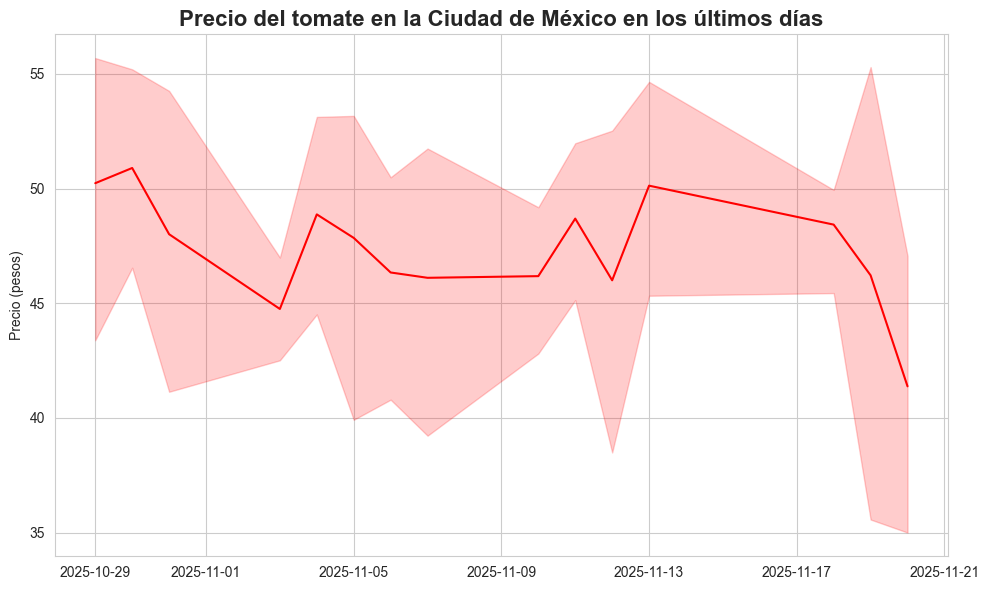

In [13]:
#Visualización del precio por fecha de observación ordenada


df_sorted = df.sort_values('fecha_observacion')
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.lineplot(data=df_sorted, x='fecha_observacion', y='precio',color='red')
plt.title('Precio del tomate en la Ciudad de México en los últimos días', fontsize=16, weight='bold')
plt.xlabel('')
plt.ylabel('Precio (pesos)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
obtener_precios_profeco("Guadalajara", "leche condensada")

Consultando PROFECO: ciudad='Guadalajara' (1401), producto='leche condensada'...


,producto,tipo_producto,precio,fecha_observacion,cadena_comercial,establecimiento,direccion,colonia,cp,municipio,entidad
7,"LECHE CONDENSADA, LA LECHERA, LATA 100 GR.",LECHE CONDENSADA,11.17,2025-10-29,CENTRAL DE ABASTOS,ABARROTES ECO,"NUEZ 2140, ENTRE MANDARINA Y AV. DEL MERCADO (...",JARDINES DE LA CRUZ,44950,Guadalajara,Jalisco
40,"LECHE CONDENSADA, LA LECHERA, LATA 100 GR.",LECHE CONDENSADA,11.17,2025-11-05,CENTRAL DE ABASTOS,ABARROTES ECO,"NUEZ 2140, ENTRE MANDARINA Y AV. DEL MERCADO (...",JARDINES DE LA CRUZ,44950,Guadalajara,Jalisco
89,"LECHE CONDENSADA, LA LECHERA, LATA 100 GR.",LECHE CONDENSADA,11.17,2025-11-19,CENTRAL DE ABASTOS,ABARROTES ECO,"NUEZ 2140, ENTRE MANDARINA Y AV. DEL MERCADO (...",JARDINES DE LA CRUZ,44950,Guadalajara,Jalisco
65,"LECHE CONDENSADA, LA LECHERA, LATA 100 GR.",LECHE CONDENSADA,11.90,2025-11-11,MERKABASTOS,MERKABASTOS SUCURSAL MARIANO OTERO,"PERIFERICO 13100, ENTRE MARIANO OTERO Y VOLCAN...",RINCONADA DEL SOL,45079,Zapopan,Jalisco
81,"LECHE CONDENSADA, LA LECHERA, LATA 100 GR.",LECHE CONDENSADA,11.90,2025-11-18,MERKABASTOS,MERKABASTOS SUCURSAL MARIANO OTERO,"PERIFERICO 13100, ENTRE MARIANO OTERO Y VOLCAN...",RINCONADA DEL SOL,45079,Zapopan,Jalisco
...,...,...,...,...,...,...,...,...,...,...,...
97,"LECHE CONDENSADA, LA LECHERA. ORIGINAL, BOTELL...",LECHE CONDENSADA,45.00,2025-11-20,CHEDRAUI,CHEDRAUI SUCURSAL ACUEDUCTO,"ACUEDUCTO 6050, ESQ. PERIFERICO",LOMAS DEL BOSQUE,45110,Zapopan,Jalisco
27,"LECHE CONDENSADA, LA LECHERA. ORIGINAL, BOTELL...",LECHE CONDENSADA,49.00,2025-11-03,WAL-MART,WAL MART SUCURSAL REVOLUCION,"RAMON LOPEZ VELARDE 821, ESQ. CALZADA REVOLUCION",LOMAS DEL PARADERO,44900,Guadalajara,Jalisco
28,"LECHE CONDENSADA, LA LECHERA. ORIGINAL, BOTELL...",LECHE CONDENSADA,49.00,2025-11-03,WAL-MART,WAL MART SUCURSAL REVOLUCION,"RAMON LOPEZ VELARDE 821, ESQ. CALZADA REVOLUCION",LOMAS DEL PARADERO,44900,Guadalajara,Jalisco
33,"LECHE CONDENSADA, LA LECHERA. ORIGINAL, BOTELL...",LECHE CONDENSADA,49.00,2025-11-03,WAL-MART,WAL MART SUCURSAL REVOLUCION,"RAMON LOPEZ VELARDE 821, ESQ. CALZADA REVOLUCION",LOMAS DEL PARADERO,44900,Guadalajara,Jalisco
